In [101]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import zipfile
import re
import os
import pickle as pk

from io import BytesIO, StringIO
from os.path import join as pj
from pathlib import Path
import matplotlib as mpl
from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility


# read in data

In [102]:
airbnb_origin2022 = pd.read_csv('listings.csv')
#airbnb_origin2022.info() #check data type, the first three columns are redundant information.

# clean names

In [71]:
# This function will clean up column names in a data frame
# credit by https://gist.github.com/burkesquires/75aeebf4554e9fa427d14354d7fe048c
def clean_dataframe_column_names(df):
    cols = df.columns
    new_column_names = []

    for col in cols:
        new_col = col.lstrip().rstrip().lower().replace (" ", "_") #strip beginning spaces, makes lowercase, add underscore
        new_column_names.append(new_col)

    df.columns = new_column_names

In [72]:
clean_dataframe_column_names(airbnb_origin2022)

In [75]:
airbnb2022 = airbnb_origin2022[['id','host_id','host_listings_count','latitude','longitude','room_type','availability_365','neighbourhood_cleansed','price']
         ]
#rename the columns (orginal is too complex)
cols = airbnb2022.columns.values
airbnb2022.columns = cols

In [76]:
airbnb2022
airbnb2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69351 entries, 0 to 69350
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      69351 non-null  int64  
 1   host_id                 69351 non-null  int64  
 2   host_listings_count     69346 non-null  float64
 3   latitude                69351 non-null  float64
 4   longitude               69351 non-null  float64
 5   room_type               69351 non-null  object 
 6   availability_365        69351 non-null  int64  
 7   neighbourhood_cleansed  69351 non-null  object 
 8   price                   69351 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 4.8+ MB


# select professional

In [96]:
airbnbprof2022 = airbnb2022[airbnb2022['host_listings_count']>1 ]
airbnbprof2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34680 entries, 0 to 69350
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      34680 non-null  int64  
 1   host_id                 34680 non-null  int64  
 2   host_listings_count     34680 non-null  float64
 3   latitude                34680 non-null  float64
 4   longitude               34680 non-null  float64
 5   room_type               34680 non-null  object 
 6   availability_365        34680 non-null  int64  
 7   neighbourhood_cleansed  34680 non-null  object 
 8   price                   34680 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 2.6+ MB


In [78]:
hostprof=airbnbprof2022.groupby(['host_id'])

In [79]:
hostprof.size()

host_id
4775          7
6774          4
10115         3
10657         2
11431         2
             ..
478119106     2
478119652     4
478388494     7
478521110    10
478532050     2
Length: 10563, dtype: int64

In [80]:
host=airbnb2022.groupby(['host_id'])
host.size()

host_id
4775         7
4879         1
5653         1
6774         4
9323         1
            ..
478781847    1
478786396    1
478789726    1
478807343    1
478853993    1
Length: 45229, dtype: int64

# aggregating Listings by ward

In [91]:
import shapefile

In [196]:
ward = gpd.read_file(os.path.join('ward.gpkg'), driver='GPKG')
ward = ward.to_crs('epsg:27700')
ward

NAME   GSS_CODE  HECTARES  NONLD_AREA  LB_GSS_CD  \
0         Chessington South  E05000405   755.173       0.000  E09000021   
1    Tolworth and Hook Rise  E05000414   259.464       0.000  E09000021   
2                Berrylands  E05000401   145.390       0.000  E09000021   
3                 Alexandra  E05000400   268.506       0.000  E09000021   
4                  Beverley  E05000402   187.821       0.000  E09000021   
..                      ...        ...       ...         ...        ...   
620               Whalebone  E05000042   155.399       0.000  E09000002   
621               Eastbrook  E05000030   345.060       0.000  E09000002   
622          Chadwell Heath  E05000029   338.422       0.000  E09000002   
623                Parsloes  E05000037   124.384       0.000  E09000002   
624          City of London  E09000001   314.943      24.546  E09000001   

                  BOROUGH  POLY_ID  \
0    Kingston upon Thames    50840   
1    Kingston upon Thames   117160   
2    Kingston upon Thames    50449   
3    Kingston upon Thames    50456   
4    Kingston upon Thames   117161   
..                    ...      ...   
620  Barking and Dagenham   117022   
621  Barking and Dagenham    50856   
622  Barking and Dagenham   117014   
623  Barking and Dagenham   117017   
624        City of London   122502   

                                              geometry  
0    MULTIPOLYGON (((516401.600 160201.800, 516407....  
1    MULTIPOLYGON (((517829.600 165447.100, 517837....  
2    MULTIPOLYGON (((518107.500 167303.400, 518114....  
3    MULTIPOLYGON (((520480.000 166909.800, 520490....  
4    MULTIPOLYGON (((522071.000 168144.900, 522063....  
..                                                 ...  
620  MULTIPOLYGON (((549410.700 187450.700, 549391....  
621  MULTIPOLYGON (((549991.500 184928.500, 549988....  
622  MULTIPOLYGON (((547715.200 187914.200, 547712....  
623  MULTIPOLYGON (((547381.600 185753.600, 547377....  
624  MULTIPOLYGON (((531361.300 180691.000, 531313....  

[625 rows x 8 columns]

In [197]:
#prof
gdfprof = gpd.GeoDataFrame(airbnbprof2022, 
      geometry=gpd.points_from_xy(airbnbprof2022['longitude'], airbnbprof2022['latitude'], crs='epsg:4326'))
gdfprof = gdfprof.to_crs('epsg:27700')

#total
gdftotal = gpd.GeoDataFrame(airbnb2022, 
      geometry=gpd.points_from_xy(airbnb2022['longitude'], airbnb2022['latitude'], crs='epsg:4326'))
gdftotal = gdftotal.to_crs('epsg:27700')

<AxesSubplot:>

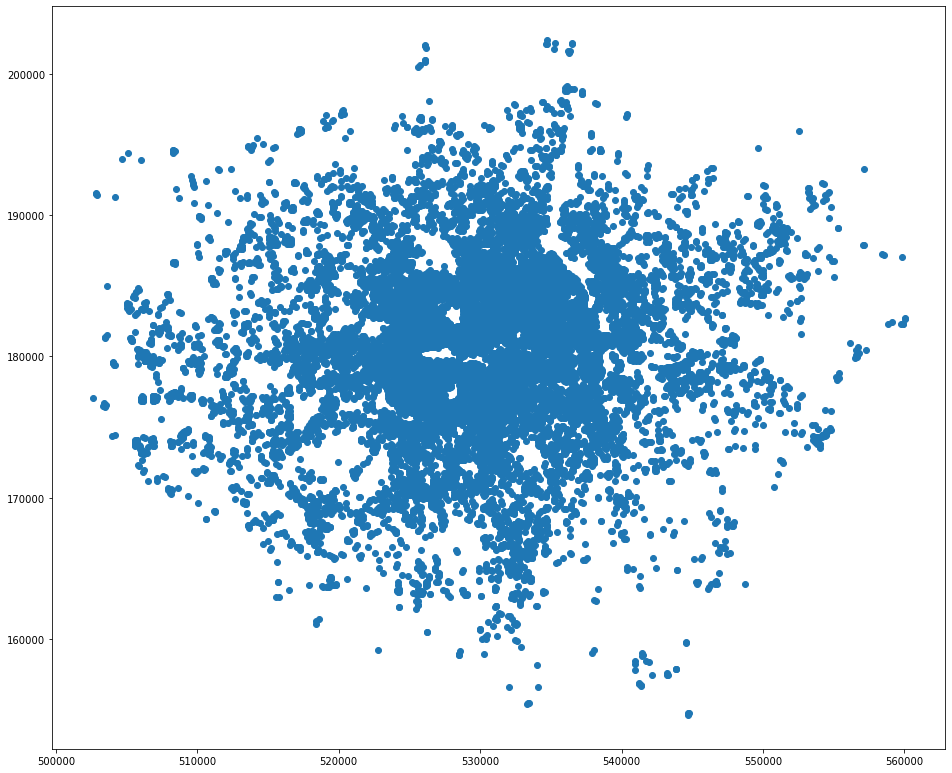

In [198]:
f,ax=plt.subplots(figsize=(16,16))
gdfprof.plot(ax=ax, legend=True, legend_kwds={'loc':'upper right', 'title':'Prof'})

In [199]:
# wl == Ward Listings
wlprof = gpd.sjoin(gdfprof, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry'])
wlprof

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


id    host_id  host_listings_count        room_type  \
0                   13913      54730                  3.0     Private room   
210                 89870      54730                  3.0  Entire home/apt   
1239              1211331    6614363                  3.0     Private room   
1821              2173226     185201                  4.0     Private room   
1924              2053193     185201                  4.0     Private room   
...                   ...        ...                  ...              ...   
56408  598124672880076606   28184118                  3.0  Entire home/apt   
60921  651883271748870344  462140387                  5.0     Private room   
58920  631026904518184628  156212093                  2.0  Entire home/apt   
62799  665959349958547726  156212093                  2.0     Private room   
68030  706393622437457303  275432341                  2.0  Entire home/apt   

       availability_365 neighbourhood_cleansed    price   GSS_CODE  
0                   343              Islington   $50.00  E05000381  
210                 343              Islington  $145.00  E05000381  
1239                314              Islington   $51.00  E05000381  
1821                  0              Islington   $35.00  E05000381  
1924                  0              Islington   $35.00  E05000381  
...                 ...                    ...      ...        ...  
56408                68                 Harrow  $500.00  E05000297  
60921                 0                 Harrow  $100.00  E05000297  
58920                73                 Sutton  $150.00  E05000556  
62799               222                 Sutton   $90.00  E05000556  
68030                91                Croydon   $67.00  E05000157  

[34351 rows x 8 columns]

In [200]:
#total
wltotal = gpd.sjoin(gdftotal, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry'])
wltotal

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


id    host_id  host_listings_count        room_type  \
0                   13913      54730                  3.0     Private room   
210                 89870      54730                  3.0  Entire home/apt   
1107               993428    5457414                  1.0     Private room   
1239              1211331    6614363                  3.0     Private room   
1461              1458193    7818548                  1.0  Entire home/apt   
...                   ...        ...                  ...              ...   
68089  707122645619496259  442648422                  3.0     Private room   
41593            41283975  203191779                  1.0  Entire home/apt   
64030  674367058773224946  212238640                  1.0  Entire home/apt   
49322            50729641  409949843                  1.0     Private room   
68030  706393622437457303  275432341                  2.0  Entire home/apt   

       availability_365 neighbourhood_cleansed    price   GSS_CODE  
0                   343              Islington   $50.00  E05000381  
210                 343              Islington  $145.00  E05000381  
1107                221              Islington   $80.00  E05000381  
1239                314              Islington   $51.00  E05000381  
1461                 59              Islington  $142.00  E05000381  
...                 ...                    ...      ...        ...  
68089               364                 Ealing   $50.00  E05000189  
41593                 0                 Bexley   $60.00  E05000067  
64030               132                 Bexley   $88.00  E05000067  
49322                 0                Croydon   $75.00  E05000157  
68030                91                Croydon   $67.00  E05000157  

[68725 rows x 8 columns]

In [201]:
wardprof = wlprof.groupby(['GSS_CODE'])[['id']].count().reset_index()
cols = wardprof.columns.values
cols[1] = 'profcount'
wardprof.columns = cols
wardprof

GSS_CODE  profcount
0    E05000026         17
1    E05000027         14
2    E05000028          9
3    E05000029          7
4    E05000030         13
..         ...        ...
616  E05000646        128
617  E05000647        278
618  E05000648        110
619  E05000649        902
620  E09000001        321

[621 rows x 2 columns]

In [202]:
wardtotal = wltotal.groupby(['GSS_CODE'])[['id']].count().reset_index()
cols = wardtotal.columns.values
cols[1] = 'totalcount'
wardtotal.columns = cols
wardtotal

GSS_CODE  totalcount
0    E05000026          60
1    E05000027          27
2    E05000028          21
3    E05000029          14
4    E05000030          17
..         ...         ...
620  E05000646         198
621  E05000647         392
622  E05000648         204
623  E05000649        1094
624  E09000001         424

[625 rows x 2 columns]

In [208]:
warddata=ward.merge(wardprof, on='GSS_CODE', how='left')
warddata=warddata.merge(wardtotal, on='GSS_CODE', how='left')
warddata['profcount'].fillna(0)
warddata.eval('percent = profcount / totalcount' , inplace=True)
warddata

NAME   GSS_CODE  HECTARES  NONLD_AREA  LB_GSS_CD  \
0         Chessington South  E05000405   755.173       0.000  E09000021   
1    Tolworth and Hook Rise  E05000414   259.464       0.000  E09000021   
2                Berrylands  E05000401   145.390       0.000  E09000021   
3                 Alexandra  E05000400   268.506       0.000  E09000021   
4                  Beverley  E05000402   187.821       0.000  E09000021   
..                      ...        ...       ...         ...        ...   
620               Whalebone  E05000042   155.399       0.000  E09000002   
621               Eastbrook  E05000030   345.060       0.000  E09000002   
622          Chadwell Heath  E05000029   338.422       0.000  E09000002   
623                Parsloes  E05000037   124.384       0.000  E09000002   
624          City of London  E09000001   314.943      24.546  E09000001   

                  BOROUGH  POLY_ID  \
0    Kingston upon Thames    50840   
1    Kingston upon Thames   117160   
2    Kingston upon Thames    50449   
3    Kingston upon Thames    50456   
4    Kingston upon Thames   117161   
..                    ...      ...   
620  Barking and Dagenham   117022   
621  Barking and Dagenham    50856   
622  Barking and Dagenham   117014   
623  Barking and Dagenham   117017   
624        City of London   122502   

                                              geometry  profcount  totalcount  \
0    MULTIPOLYGON (((516401.600 160201.800, 516407....        9.0          16   
1    MULTIPOLYGON (((517829.600 165447.100, 517837....        6.0          15   
2    MULTIPOLYGON (((518107.500 167303.400, 518114....       21.0          37   
3    MULTIPOLYGON (((520480.000 166909.800, 520490....        2.0          14   
4    MULTIPOLYGON (((522071.000 168144.900, 522063....       15.0          33   
..                                                 ...        ...         ...   
620  MULTIPOLYGON (((549410.700 187450.700, 549391....       10.0          20   
621  MULTIPOLYGON (((549991.500 184928.500, 549988....       13.0          17   
622  MULTIPOLYGON (((547715.200 187914.200, 547712....        7.0          14   
623  MULTIPOLYGON (((547381.600 185753.600, 547377....        4.0           9   
624  MULTIPOLYGON (((531361.300 180691.000, 531313....      321.0         424   

      percent  
0    0.562500  
1    0.400000  
2    0.567568  
3    0.142857  
4    0.454545  
..        ...  
620  0.500000  
621  0.764706  
622  0.500000  
623  0.444444  
624  0.757075  

[625 rows x 11 columns]

# mapping

AttributeError: 'Map' object has no attribute 'plot'

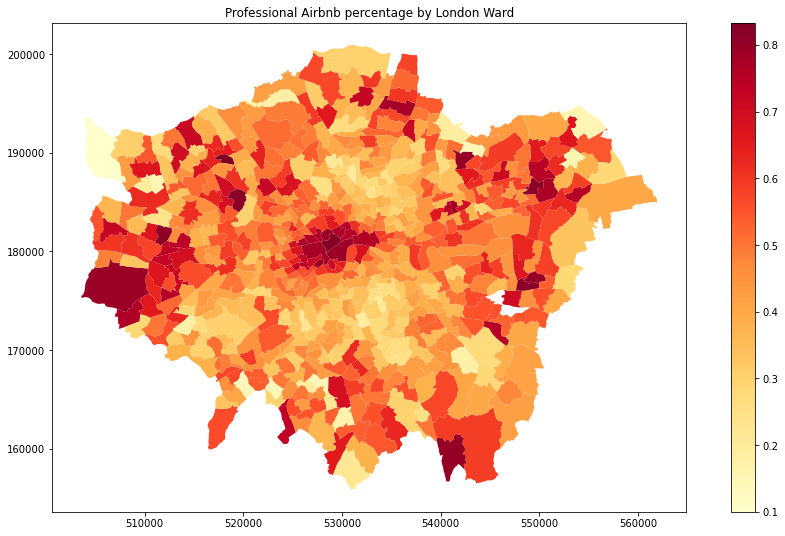

In [215]:
fig, ax = plt.subplots(figsize =(16,9))
warddata.plot(ax=ax, column = 'percent', cmap = "YlOrRd",  legend = True, figsize=(16, 9))
ax.set_title('Professional Airbnb percentage by London Ward')
plt.savefig('Professional Airbnb percentage by London Ward')